In [2]:
import pandas as pd
import time
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
mpl.rcParams['font.sans-serif'] = ['SimHei']
mpl.rcParams['font.serif'] = ['SimHei']
import warnings
warnings.filterwarnings('ignore')

In [3]:
pd.set_option('display.max_columns', 100)

In [4]:
f = open('D:\\Jupyter\\datawhale\\Datawhale_7\\1\\data.csv')
train_data = pd.read_csv(f,index_col=0)
train_data.head()

,custid,trade_no,bank_card_no,low_volume_percent,middle_volume_percent,take_amount_in_later_12_month_highest,trans_amount_increase_rate_lately,trans_activity_month,trans_activity_day,transd_mcc,trans_days_interval_filter,trans_days_interval,regional_mobility,student_feature,repayment_capability,is_high_user,number_of_trans_from_2011,first_transaction_time,historical_trans_amount,historical_trans_day,rank_trad_1_month,trans_amount_3_month,avg_consume_less_12_valid_month,abs,top_trans_count_last_1_month,avg_price_last_12_month,avg_price_top_last_12_valid_month,reg_preference_for_trad,trans_top_time_last_1_month,trans_top_time_last_6_month,consume_top_time_last_1_month,consume_top_time_last_6_month,cross_consume_count_last_1_month,trans_fail_top_count_enum_last_1_month,trans_fail_top_count_enum_last_6_month,trans_fail_top_count_enum_last_12_month,consume_mini_time_last_1_month,max_cumulative_consume_later_1_month,max_consume_count_later_6_month,railway_consume_count_last_12_month,pawns_auctions_trusts_consume_last_1_month,pawns_auctions_trusts_consume_last_6_month,jewelry_consume_count_last_6_month,status,source,first_transaction_day,trans_day_last_12_month,id_name,apply_score,apply_credibility,query_org_count,query_finance_count,query_cash_count,query_sum_count,latest_query_time,latest_one_month_apply,latest_three_month_apply,latest_six_month_apply,loans_score,loans_credibility_behavior,loans_count,loans_settle_count,loans_overdue_count,loans_org_count_behavior,consfin_org_count_behavior,loans_cash_count,latest_one_month_loan,latest_three_month_loan,latest_six_month_loan,history_suc_fee,history_fail_fee,latest_one_month_suc,latest_one_month_fail,loans_long_time,loans_latest_time,loans_credit_limit,loans_credibility_limit,loans_org_count_current,loans_product_count,loans_max_limit,loans_avg_limit,consfin_credit_limit,consfin_credibility,consfin_org_count_current,consfin_product_count,consfin_max_limit,consfin_avg_limit,latest_query_day,loans_latest_day
5,2791858,20180507115231274000000023057383,卡号1,0.01,0.99,0,0.90,0.55,0.313,17.0,27.0,26.0,3.0,NaN,19890,0,30.0,20130817.0,149050,151.0,0.40,34030,7.0,3920,0.15,1020,0.55,一线城市,4.0,19.0,4.0,19.0,1.0,1.0,2.0,2.0,5.0,2170,6.0,0.0,1970,18040,0.0,1,xs,1738.0,85.0,蒋红,583.0,79.0,8.0,2.0,6.0,10.0,2018-04-25,2.0,5.0,8.0,552.0,73.0,37.0,34.0,2.0,10.0,1.0,9.0,1.0,1.0,13.0,37.0,7.0,1.0,0.0,341.0,2018-04-19,2200.0,72.0,9.0,10.0,2900.0,1688.0,1200.0,75.0,1.0,2.0,1200.0,1200.0,12.0,18.0
10,534047,20180507121002192000000023073000,卡号1,0.02,0.94,2000,1.28,1.00,0.458,19.0,30.0,14.0,4.0,1.0,16970,0,23.0,20160402.0,302910,224.0,0.35,10590,5.0,6950,0.05,1210,0.50,一线城市,13.0,30.0,13.0,30.0,0.0,0.0,3.0,3.0,330.0,2100,9.0,0.0,1820,15680,0.0,0,xs,779.0,84.0,崔向朝,653.0,73.0,7.0,4.0,2.0,8.0,2018-05-03,2.0,6.0,8.0,635.0,76.0,37.0,36.0,0.0,17.0,5.0,12.0,2.0,2.0,8.0,49.0,4.0,2.0,1.0,353.0,2018-05-05,2000.0,74.0,12.0,12.0,3500.0,1758.0,15100.0,80.0,5.0,6.0,22800.0,9360.0,4.0,2.0
12,2849787,20180507125159718000000023114911,卡号1,0.04,0.96,0,1.00,1.00,0.114,13.0,68.0,22.0,1.0,NaN,9710,0,9.0,20170617.0,11520,31.0,1.00,5710,5.0,840,0.65,570,0.65,一线城市,0.0,68.0,0.0,68.0,0.0,3.0,6.0,6.0,0.0,0,3.0,0.0,0,0,0.0,1,xs,338.0,95.0,王中云,654.0,76.0,11.0,5.0,5.0,16.0,2018-05-05,5.0,5.0,14.0,633.0,83.0,4.0,2.0,0.0,3.0,1.0,2.0,2.0,2.0,4.0,2.0,2.0,1.0,1.0,157.0,2018-05-01,1500.0,77.0,2.0,2.0,1600.0,1250.0,4200.0,87.0,1.0,1.0,4200.0,4200.0,2.0,6.0
13,1809708,20180507121358683000000388283484,卡号1,0.00,0.96,2000,0.13,0.57,0.777,22.0,14.0,6.0,3.0,NaN,6210,0,33.0,20130516.0,491130,360.0,0.15,91690,7.0,46850,0.05,1290,0.45,三线城市,6.0,8.0,6.0,8.0,0.0,1.0,8.0,8.0,31700.0,8140,9.0,0.0,2700,27970,0.0,0,xs,1831.0,82.0,何洋洋,595.0,79.0,12.0,7.0,4.0,22.0,2018-05-05,3.0,16.0,17.0,542.0,75.0,85.0,81.0,4.0,22.0,5.0,17.0,2.0,4.0,34.0,91.0,26.0,2.0,0.0,355.0,2018-05-03,1800.0,74.0,17.0,18.0,3200.0,1541.0,16300.0,80.0,5.0,5.0,30000.0,12180.0,2.0,4.0
14,2499829,20180507115448545000000388205844,卡号1,0.01,0.99,0,0.46,1.00,0.175,13.0,66.0,42.0,1.0,NaN,11150,0,12.0,20

In [5]:
len(train_data)

4754

In [5]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4754 entries, 5 to 11992
Data columns (total 89 columns):
custid                                        4754 non-null int64
trade_no                                      4754 non-null object
bank_card_no                                  4754 non-null object
low_volume_percent                            4752 non-null float64
middle_volume_percent                         4752 non-null float64
take_amount_in_later_12_month_highest         4754 non-null int64
trans_amount_increase_rate_lately             4751 non-null float64
trans_activity_month                          4752 non-null float64
trans_activity_day                            4752 non-null float64
transd_mcc                                    4752 non-null float64
trans_days_interval_filter                    4746 non-null float64
trans_days_interval                           4752 non-null float64
regional_mobility                             4752 non-null float64
student_featur

In [6]:
#dataset = train_data.fillna(-1)   # 查看行列缺失值
#print((dataset == -1).sum(axis = 0))
#print((dataset == -1).sum(axis = 1))

In [6]:
#缺失值排序
train_data.isnull().sum().sort_values(ascending = False)

student_feature                               2998
cross_consume_count_last_1_month               426
query_org_count                                304
query_cash_count                               304
latest_six_month_apply                         304
latest_three_month_apply                       304
latest_query_time                              304
query_sum_count                                304
latest_one_month_apply                         304
query_finance_count                            304
apply_credibility                              304
apply_score                                    304
latest_query_day                               304
latest_one_month_loan                          297
loans_score                                    297
loans_credibility_behavior                     297
loans_count                                    297
loans_settle_count                             297
loans_overdue_count                            297
loans_org_count_behavior       

In [7]:
train_data.drop(['student_feature'],axis=1,inplace=True)

In [8]:
for i in range(len(train_data.columns)):
    if (train_data[train_data.columns[i]]).dtype == 'object':
        print(train_data.columns[i])

trade_no
bank_card_no
reg_preference_for_trad
source
id_name
latest_query_time
loans_latest_time


In [9]:
#无关特征丢掉
train_data.drop(['bank_card_no','source','id_name'],axis=1,inplace=True)

In [10]:
print(train_data['reg_preference_for_trad'].unique())
train_data['reg_preference_for_trad'].value_counts()

['一线城市' '三线城市' '境外' '二线城市' '其他城市' nan]


一线城市    3403
三线城市    1064
境外       150
二线城市     131
其他城市       4
Name: reg_preference_for_trad, dtype: int64

In [11]:
#中位数填充
train_data['reg_preference_for_trad'].fillna(train_data['reg_preference_for_trad'].mode(),inplace=True)
train_data['reg_preference_for_trad'].value_counts()

一线城市    3403
三线城市    1064
境外       150
二线城市     131
其他城市       4
Name: reg_preference_for_trad, dtype: int64

In [12]:
#one-hot
train_data = train_data.join(pd.get_dummies(train_data['reg_preference_for_trad']))
train_data.drop(['reg_preference_for_trad'],axis=1,inplace=True)
train_data.head()

,custid,trade_no,low_volume_percent,middle_volume_percent,take_amount_in_later_12_month_highest,trans_amount_increase_rate_lately,trans_activity_month,trans_activity_day,transd_mcc,trans_days_interval_filter,trans_days_interval,regional_mobility,repayment_capability,is_high_user,number_of_trans_from_2011,first_transaction_time,historical_trans_amount,historical_trans_day,rank_trad_1_month,trans_amount_3_month,avg_consume_less_12_valid_month,abs,top_trans_count_last_1_month,avg_price_last_12_month,avg_price_top_last_12_valid_month,trans_top_time_last_1_month,trans_top_time_last_6_month,consume_top_time_last_1_month,consume_top_time_last_6_month,cross_consume_count_last_1_month,trans_fail_top_count_enum_last_1_month,trans_fail_top_count_enum_last_6_month,trans_fail_top_count_enum_last_12_month,consume_mini_time_last_1_month,max_cumulative_consume_later_1_month,max_consume_count_later_6_month,railway_consume_count_last_12_month,pawns_auctions_trusts_consume_last_1_month,pawns_auctions_trusts_consume_last_6_month,jewelry_consume_count_last_6_month,status,first_transaction_day,trans_day_last_12_month,apply_score,apply_credibility,query_org_count,query_finance_count,query_cash_count,query_sum_count,latest_query_time,latest_one_month_apply,latest_three_month_apply,latest_six_month_apply,loans_score,loans_credibility_behavior,loans_count,loans_settle_count,loans_overdue_count,loans_org_count_behavior,consfin_org_count_behavior,loans_cash_count,latest_one_month_loan,latest_three_month_loan,latest_six_month_loan,history_suc_fee,history_fail_fee,latest_one_month_suc,latest_one_month_fail,loans_long_time,loans_latest_time,loans_credit_limit,loans_credibility_limit,loans_org_count_current,loans_product_count,loans_max_limit,loans_avg_limit,consfin_credit_limit,consfin_credibility,consfin_org_count_current,consfin_product_count,consfin_max_limit,consfin_avg_limit,latest_query_day,loans_latest_day,一线城市,三线城市,二线城市,其他城市,境外
5,2791858,20180507115231274000000023057383,0.01,0.99,0,0.90,0.55,0.313,17.0,27.0,26.0,3.0,19890,0,30.0,20130817.0,149050,151.0,0.40,34030,7.0,3920,0.15,1020,0.55,4.0,19.0,4.0,19.0,1.0,1.0,2.0,2.0,5.0,2170,6.0,0.0,1970,18040,0.0,1,1738.0,85.0,583.0,79.0,8.0,2.0,6.0,10.0,2018-04-25,2.0,5.0,8.0,552.0,73.0,37.0,34.0,2.0,10.0,1.0,9.0,1.0,1.0,13.0,37.0,7.0,1.0,0.0,341.0,2018-04-19,2200.0,72.0,9.0,10.0,2900.0,1688.0,1200.0,75.0,1.0,2.0,1200.0,1200.0,12.0,18.0,1,0,0,0,0
10,534047,20180507121002192000000023073000,0.02,0.94,2000,1.28,1.00,0.458,19.0,30.0,14.0,4.0,16970,0,23.0,20160402.0,302910,224.0,0.35,10590,5.0,6950,0.05,1210,0.50,13.0,30.0,13.0,30.0,0.0,0.0,3.0,3.0,330.0,2100,9.0,0.0,1820,15680,0.0,0,779.0,84.0,653.0,73.0,7.0,4.0,2.0,8.0,2018-05-03,2.0,6.0,8.0,635.0,76.0,37.0,36.0,0.0,17.0,5.0,12.0,2.0,2.0,8.0,49.0,4.0,2.0,1.0,353.0,2018-05-05,2000.0,74.0,12.0,12.0,3500.0,1758.0,15100.0,80.0,5.0,6.0,22800.0,9360.0,4.0,2.0,1,0,0,0,0
12,2849787,20180507125159718000000023114911,0.04,0.96,0,1.00,1.00,0.114,13.0,68.0,22.0,1.0,9710,0,9.0,20170617.0,11520,31.0,1.00,5710,5.0,840,0.65,570,0.65,0.0,68.0,0.0,68.0,0.0,3.0,6.0,6.0,0.0,0,3.0,0.0,0,0,0.0,1,338.0,95.0,654.0,76.0,11.0,5.0,5.0,16.0,2018-05-05,5.0,5.0,14.0,633.0,83.0,4.0,2.0,0.0,3.0,1.0,2.0,2.0,2.0,4.0,2.0,2.0,1.0,1.0,157.0,2018-05-01,1500.0,77.0,2.0,2.0,1600.0,1250.0,4200.0,87.0,1.0,1.0,4200.0,4200.0,2.0,6.0,1,0,0,0,0
13,1809708,20180507121358683000000388283484,0.00,0.96,2000,0.13,0.57,0.777,22.0,14.0,6.0,3.0,6210,0,33.0,20130516.0,491130,360.0,0.15,91690,7.0,46850,0.05,1290,0.45,6.0,8.0,6.0,8.0,0.0,1.0,8.0,8.0,31700.0,8140,9.0,0.0,2700,27970,0.0,0,1831.0,82.0,595.0,79.0,12.0,7.0,4.0,22.0,2018-05-05,3.0,16.0,17.0,542.0,75.0,85.0,81.0,4.0,22.0,5.0,17.0,2.0,4.0,34.0,91.0,26.0,2.0,0.0,355.0,2018-05-03,1800.0,74.0,17.0,18.0,3200.0,1541.0,16300.0,80.0,5.0,5.0,30000.0,12180.0,2.0,4.0,0,1,0,0,0
14,2499829,20180507115448545000000388205844,0.01,0.99,0,0.46,1.00,0.175,13.0,66.0,42.0,1.0,11150,0,12.0,20170312.0,61470,63.0,0.65,9770,6.0,760,1.00,1110,0.50,0.0,66.0,0.0,66.0,0.0,3.0,3.0,3.0,0.0,1

In [13]:
#train_data['latest_query_time'] = train_data.latest_query_time.astype(str)
#train_data['loans_latest_time'] = train_data.loans_latest_time.astype(str)
train_data['latest_query_time'] = pd.to_datetime(train_data['latest_query_time'],format='%Y-%m-%d %H:%M:%S.%f')
train_data['loans_latest_time'] = pd.to_datetime(train_data['loans_latest_time'],format='%Y-%m-%d %H:%M:%S.%f')

In [14]:
import datetime
a = (datetime.datetime.today() - train_data['loans_latest_time'])
b = map(lambda a:a.days,a)
train_data['loans_latest_time'] = pd.Series(b)
a = (datetime.datetime.today() - train_data['latest_query_time'])
b = map(lambda a:a.days,a)
train_data['latest_query_time'] = pd.Series(b)

In [15]:
#数值型特征均值填充
train_data = train_data.select_dtypes(include=['number']).copy()
print(train_data.shape)
num_miss_rate = 1 - train_data.count() / len(train_data)
num_miss_rate.sort_values(ascending = False)[:15]

(4754, 88)


latest_query_time                   0.632730
loans_latest_time                   0.631889
cross_consume_count_last_1_month    0.089609
apply_credibility                   0.063946
apply_score                         0.063946
query_org_count                     0.063946
query_finance_count                 0.063946
query_cash_count                    0.063946
query_sum_count                     0.063946
latest_one_month_apply              0.063946
latest_six_month_apply              0.063946
latest_three_month_apply            0.063946
latest_query_day                    0.063946
consfin_credit_limit                0.062474
loans_cash_count                    0.062474
dtype: float64

In [16]:
train_data.fillna(train_data.mean(),inplace=True)

In [17]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4754 entries, 5 to 11992
Data columns (total 88 columns):
custid                                        4754 non-null int64
low_volume_percent                            4754 non-null float64
middle_volume_percent                         4754 non-null float64
take_amount_in_later_12_month_highest         4754 non-null int64
trans_amount_increase_rate_lately             4754 non-null float64
trans_activity_month                          4754 non-null float64
trans_activity_day                            4754 non-null float64
transd_mcc                                    4754 non-null float64
trans_days_interval_filter                    4754 non-null float64
trans_days_interval                           4754 non-null float64
regional_mobility                             4754 non-null float64
repayment_capability                          4754 non-null int64
is_high_user                                  4754 non-null int64
number_of_trans_

In [18]:
#相关性分析
cor = train_data.corr()
corr1 = np.abs(cor['status'].sort_values(ascending=False)).to_frame(name='corelation').reset_index()
print(type(np.abs(cor['status'].sort_values(ascending=False))))

<class 'pandas.core.series.Series'>


In [39]:
#corr1.sort_values(ascending=False)[train_data.isnull().sum().sort_values(ascending= False).keys()[:43]].sort_values(ascending=False)

In [19]:
#选取特征大于0.05的列保留
deleted_corr = list(corr1[corr1.corelation < 0.05]['index'])
print(deleted_corr)
train_data.drop(deleted_corr,inplace=True,axis=1)

['loans_count', 'middle_volume_percent', 'first_transaction_time', 'consfin_product_count', 'consfin_org_count_current', 'consfin_org_count_behavior', 'loans_org_count_behavior', 'railway_consume_count_last_12_month', 'loans_product_count', 'consume_top_time_last_6_month', 'loans_latest_day', 'loans_cash_count', 'loans_org_count_current', 'query_sum_count', 'trans_top_time_last_6_month', '境外', 'query_org_count', 'loans_latest_time', 'loans_long_time', 'max_consume_count_later_6_month', 'trans_days_interval', 'trans_activity_month', '其他城市', 'loans_credibility_limit', '三线城市', 'latest_six_month_apply', 'query_finance_count', 'transd_mcc', 'take_amount_in_later_12_month_highest', 'loans_credibility_behavior', 'jewelry_consume_count_last_6_month', 'trans_days_interval_filter', 'trans_amount_increase_rate_lately', '一线城市', 'repayment_capability', 'abs', 'latest_query_time', 'cross_consume_count_last_1_month', 'latest_three_month_apply', 'loans_avg_limit', '二线城市', 'trans_activity_day', 'consum

In [20]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4754 entries, 5 to 11992
Data columns (total 26 columns):
custid                                     4754 non-null int64
low_volume_percent                         4754 non-null float64
rank_trad_1_month                          4754 non-null float64
top_trans_count_last_1_month               4754 non-null float64
avg_price_last_12_month                    4754 non-null int64
avg_price_top_last_12_valid_month          4754 non-null float64
trans_top_time_last_1_month                4754 non-null float64
consume_top_time_last_1_month              4754 non-null float64
trans_fail_top_count_enum_last_1_month     4754 non-null float64
trans_fail_top_count_enum_last_6_month     4754 non-null float64
trans_fail_top_count_enum_last_12_month    4754 non-null float64
status                                     4754 non-null int64
trans_day_last_12_month                    4754 non-null float64
apply_score                                4754 non-n

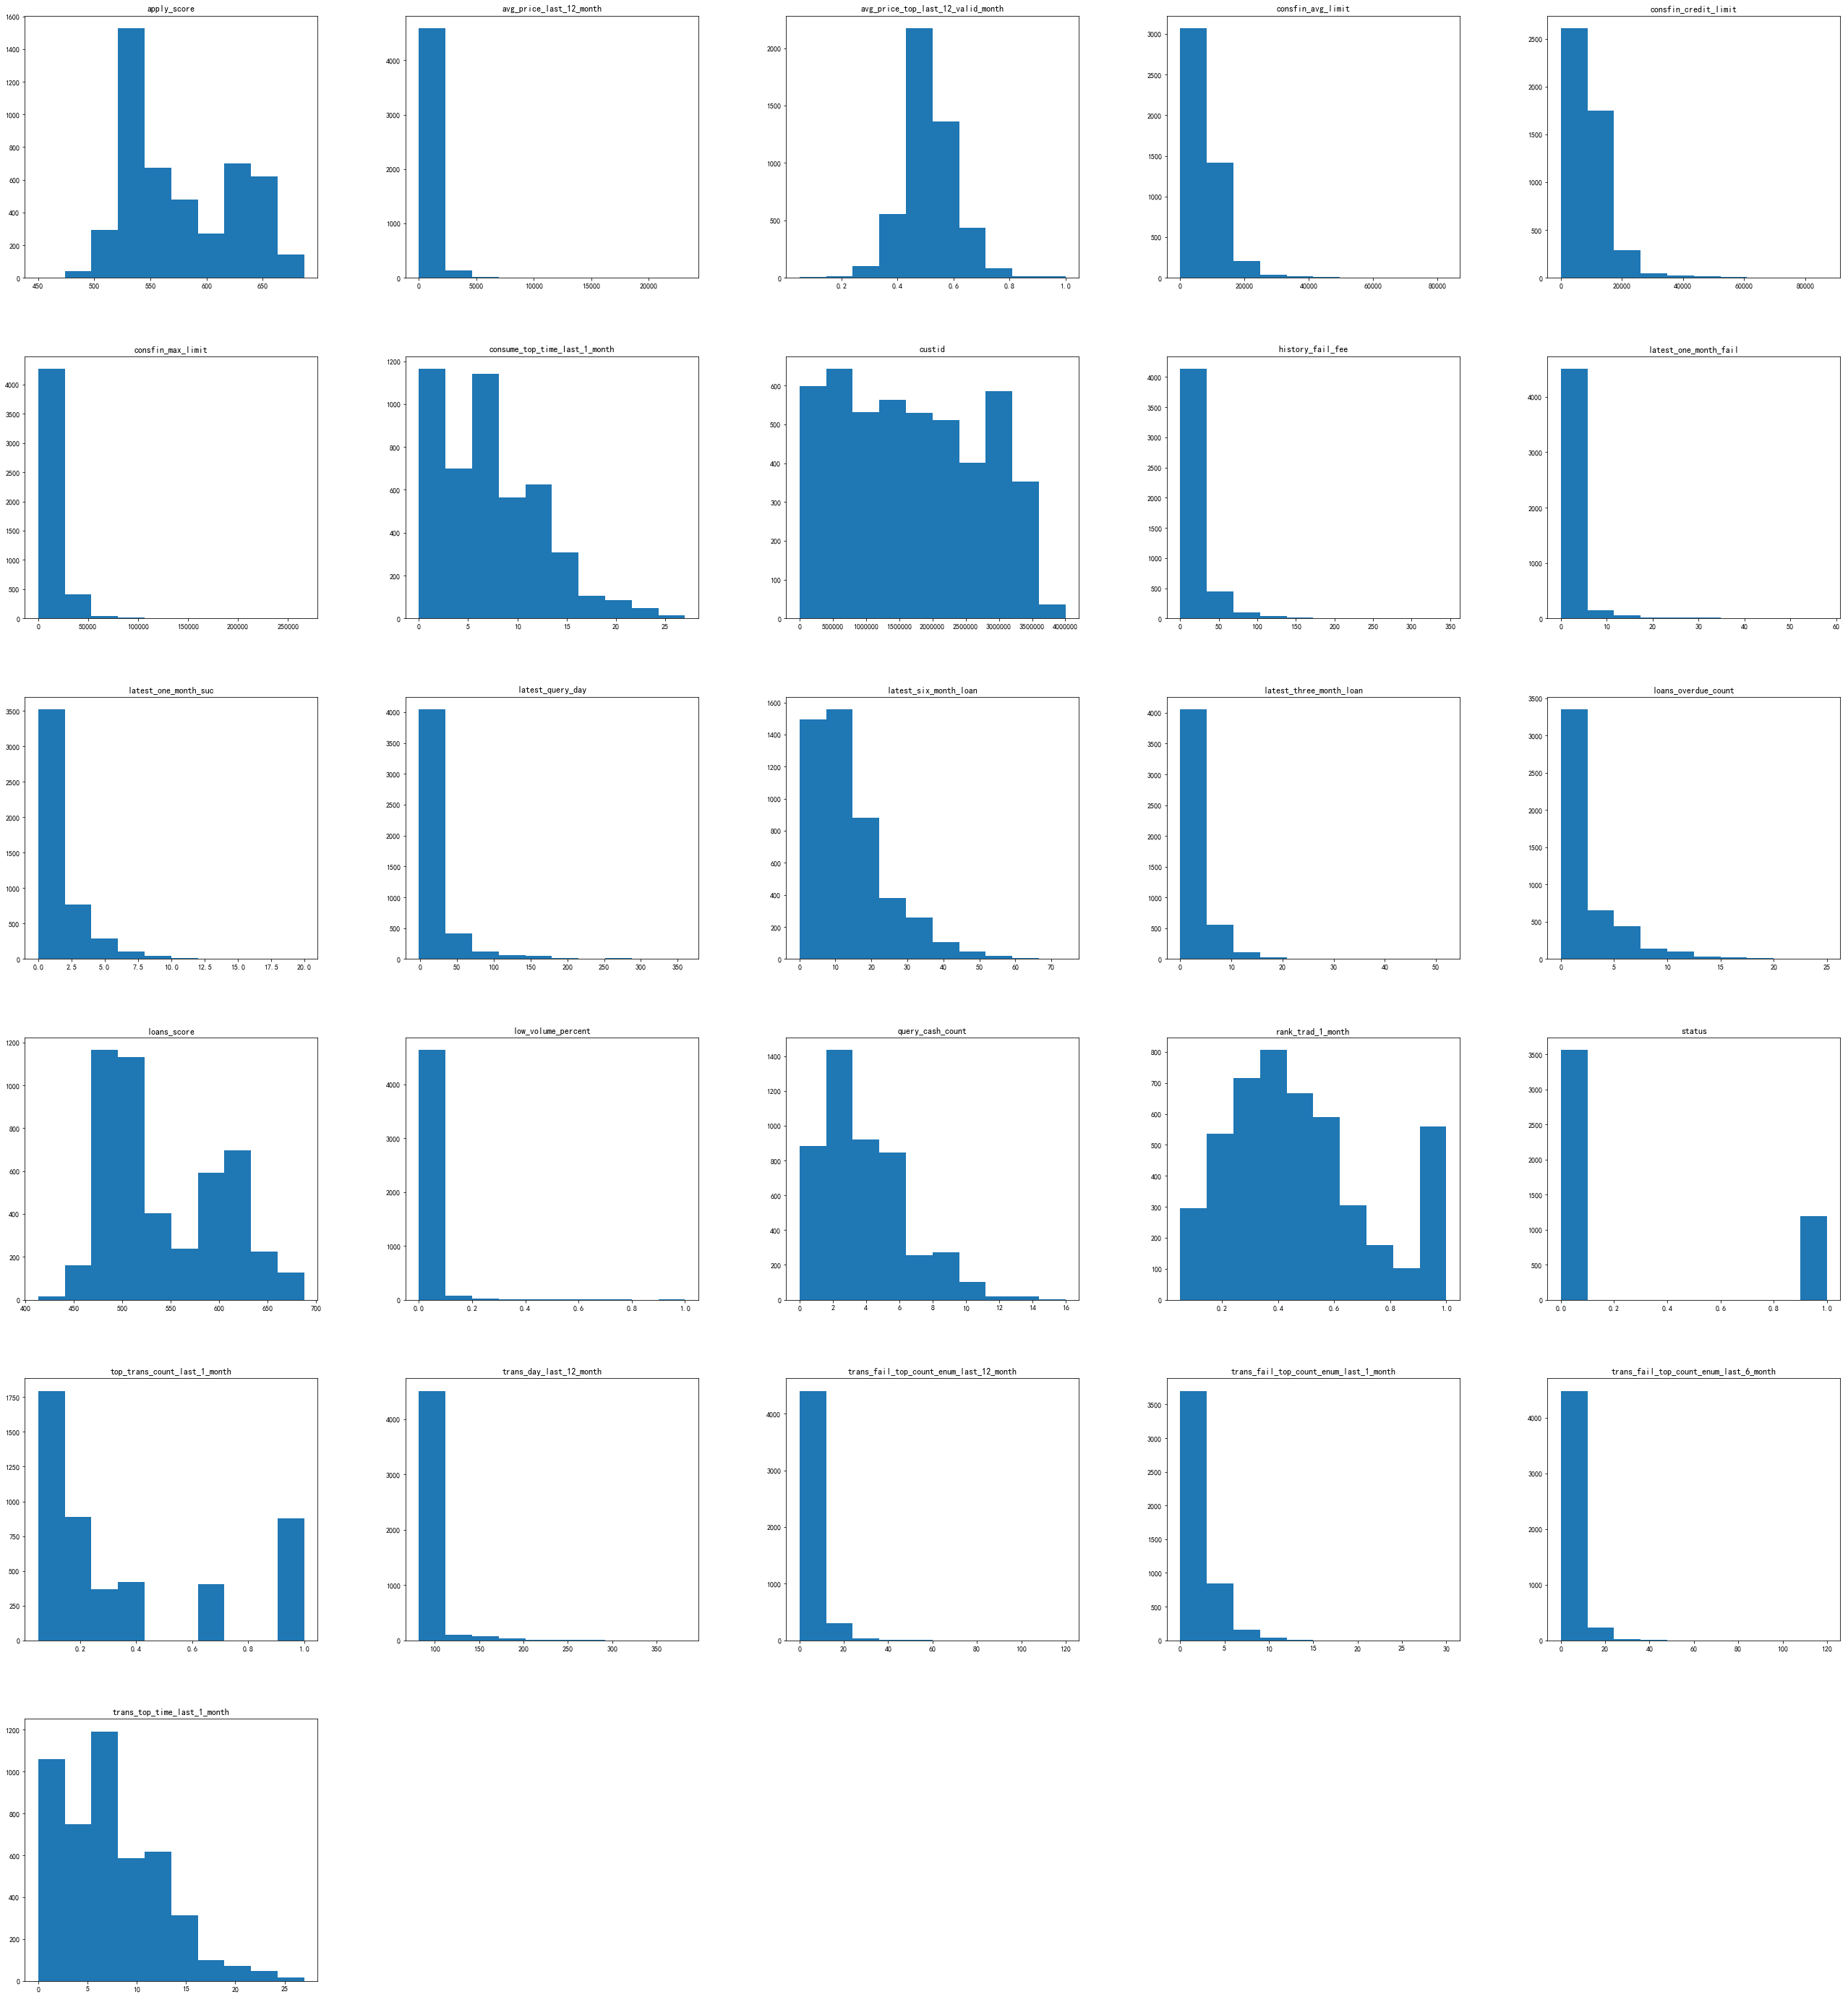

In [21]:
train_data.hist(figsize=(45,50),grid=False)
plt.show()

In [25]:
#for i in train_data.keys():
#    train_data[i].fillna(train_data[i].median(),inplace=True)
#train_data.isnull().sum().sort_values(ascending=False)

In [22]:
y = train_data.status
train_data.drop(['status'],axis=1)
X = train_data

In [23]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.3,random_state = 2018)

### 引入iv值 参考大佬的代码

#### 在机器学习的二分类问题中，IV值（Information Value）主要用来对输入变量进行编码和预测能力评估。特征变量IV值的大小即表示该变量预测能力的强弱。IV 值的取值范围是 [0, 正无穷)，如果当前分组中只包含响应客户或者未响应客户时，IV = 正无穷。

In [24]:
#定义计算iv值的函数
def calc_iv(train_data, feature, target, pr=False):
    """
    Set pr=True to enable printing of output.

    Output:
      * iv: float,
      * data: pandas.DataFrame
    """
    lst = []
    train_data[feature] = train_data[feature].fillna('NULL')

    for i in range(train_data[feature].nunique()):  # nuinque()是查看该序列(axis=0/1对应着列或行)的不同值的数量个数
        val = list(train_data[feature].unique())[i]
        lst.append([feature,
                    val,  # Value
                    train_data[train_data[feature] == val].count()[feature],  # all
                    train_data[(train_data[feature] == val) & (train_data[target] == 0)].count()[feature],  # good rate
                    train_data[(train_data[feature] == val) & (train_data[target] == 1)].count()[feature]])  # bad rate
    data = pd.DataFrame(lst, columns=['Variable', 'Value', 'All', 'Good', 'Bad'])

    data['Share'] = data['All'] / data['All'].sum()
    data['Bad Rate'] = data['Bad'] / data['All']
    data['Distribution Good'] = (data['All'] - data['Bad']) / (data['All'].sum() - data['Bad'].sum())
    data['Distribution Bad'] = data['Bad'] / data['Bad'].sum()
    data['WoE'] = np.log(data['Distribution Good'] / data['Distribution Bad'])

    data = data.replace({'WoE': {np.inf: 0, -np.inf: 0}})

    data['IV'] = data['WoE'] * (data['Distribution Good'] - data['Distribution Bad'])

    data = data.sort_values(by=['Variable', 'Value'], ascending=[True, True])
    data.index = range(len(data.index))

    if pr:
        print(data)
        print("IV = ", data['IV'].sum())

    iv = data['IV'].sum()

    return iv, data

column_headers = list(train_data.columns.values)
# print(column_headers)

d=[]
for x in column_headers:
    IV_1, data = calc_iv(train_data, x, 'status')
    d.append(IV_1)
#整理成Series类型并合并
column_headers=pd.Series(column_headers,name='feature')
d=pd.Series(d,name='iv_value')

# print(column_headers)
iv_result=pd.concat([column_headers,d],axis=1)
iv_result.sort_values(by='iv_value',ascending=False)

,feature,iv_value
15,loans_score,0.621493
8,trans_fail_top_count_enum_last_1_month,0.594555
19,history_fail_fee,0.513355
13,apply_score,0.491895
16,loans_overdue_count,0.392336
9,trans_fail_top_count_enum_last_6_month,0.278358
24,consfin_avg_limit,0.275121
10,trans_fail_top_count_enum_last_12_month,0.264929
21,latest_one_month_fail,0.255931
22,consfin_credit_limit,0.214737


In [1]:
#from sklearn.preprocessing import StandardScaler
#columns = list(X_train)
#X_train = StandardScaler().fit_transform(X_train)
#X_train = pd.DataFrame(X_train,columns=columns)

#X_test= StandardScaler().fit_transform(X_test)
#X_test= pd.DataFrame(X_test,columns=columns)

### lgb快速训练

In [25]:
from sklearn.model_selection import GridSearchCV

print('Start training...')
# train
gbm = lgb.LGBMRegressor(objective='regression',
                        num_leaves=31,
                        learning_rate=0.05,
                        n_estimators=20)

print('Start predicting...')
print('Calculate feature importances...')
estimator = lgb.LGBMRegressor(num_leaves=31)
param_grid = {
    'learning_rate': [0.01, 0.1, 1],
    'n_estimators': [20, 40]
}

gbm = GridSearchCV(estimator, param_grid)

gbm.fit(X_train, y_train)
print('Best parameters found by grid search are:', gbm.best_params_)

Start training...
Start predicting...
Calculate feature importances...
Best parameters found by grid search are: {'learning_rate': 1, 'n_estimators': 20}


In [26]:
lgb_train = lgb.Dataset(X_train, y_train, free_raw_data=False)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train,free_raw_data=False)

# specify your configurations as a dict
seed = 13
params2 = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    #'metric': 'binary_logloss',
    'metric': 'auc',
    'num_leaves': 31,
    'learning_rate': 1,
    'feature_fraction': 0.7,
    'bagging_fraction': 1,
    'bagging_freq': 10,
    'verbose': 0,
    #'num_iterations':500,
    'tree_learner':'serial',  
    'min_data_in_leaf':10,
    'feature_fraction_seed':seed,
    'bagging_seed':seed,
    'metric_freq':1 
}

print('Start training...')
# train
gbm = lgb.train(params2,
                lgb_train,
                num_boost_round=1000,
                valid_sets=lgb_eval,
                early_stopping_rounds=10)

Start training...
[1]	valid_0's auc: 0.716393
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's auc: 0.734737
[3]	valid_0's auc: 0.995081
[4]	valid_0's auc: 0.999932
[5]	valid_0's auc: 1
[6]	valid_0's auc: 1
[7]	valid_0's auc: 1
[8]	valid_0's auc: 1
[9]	valid_0's auc: 1
[10]	valid_0's auc: 1
[11]	valid_0's auc: 1
[12]	valid_0's auc: 1
[13]	valid_0's auc: 1
[14]	valid_0's auc: 1
[15]	valid_0's auc: 1
[16]	valid_0's auc: 1
[17]	valid_0's auc: 1
[18]	valid_0's auc: 1
[19]	valid_0's auc: 1
[20]	valid_0's auc: 1
[21]	valid_0's auc: 1
[22]	valid_0's auc: 1
[23]	valid_0's auc: 1
[24]	valid_0's auc: 1
[25]	valid_0's auc: 1
[26]	valid_0's auc: 1
[27]	valid_0's auc: 1
[28]	valid_0's auc: 1
[29]	valid_0's auc: 1
[30]	valid_0's auc: 1
[31]	valid_0's auc: 1
[32]	valid_0's auc: 1
[33]	valid_0's auc: 1
[34]	valid_0's auc: 1
[35]	valid_0's auc: 1
[36]	valid_0's auc: 1
[37]	valid_0's auc: 1
[38]	valid_0's auc: 1
[39]	valid_0's auc: 1
[40]	valid_0's auc: 1
[41]	valid_0's auc: 

<Figure size 3600x1440 with 0 Axes>

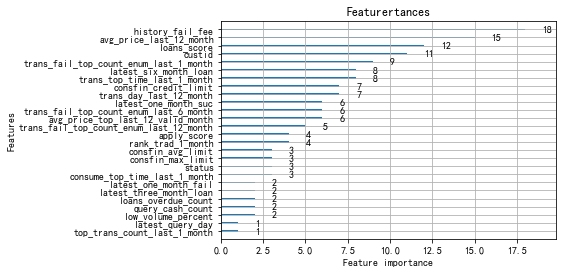

In [27]:
plt.figure(figsize=(50,20))
lgb.plot_importance(gbm, max_num_features=30)
plt.title("Featurertances")
plt.show()

In [28]:
from sklearn import metrics
def ks(y_predicted, y_true):
    label=y_true
    #label = y_true.get_label()
    fpr,tpr,thres = metrics.roc_curve(label,y_predicted,pos_label=1)
    return 'ks',abs(fpr - tpr).max()

In [29]:
preds_offline = gbm.predict(X_test, num_iteration=gbm.best_iteration)
print("线下得分;")
print(ks(preds_offline,y_test))

线下得分;
('ks', 1.0)


In [ ]:
#过拟合了 IV值 和其他相关性的分析 用一个就行 我这全用了 